In [15]:
import os
import pandas as pd
from html_similarity import style_similarity, structural_similarity, similarity
from bs4 import BeautifulSoup, Doctype
from bs4.element import Comment
from collections import Counter
from scipy.spatial import distance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string
import spacy
from nltk.metrics import edit_distance
from nltk.metrics import edit_distance
from nltk.metrics import interval_distance
from nltk import jaccard_distance
import textdistance
import datetime
import fbprophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [3]:
def text_from_html(htmlPage):
    soup = BeautifulSoup(htmlPage, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)

In [4]:
def split(word): 
    return [char for char in word]

In [5]:
def filter_text(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(split(string.punctuation))
    nlp = spacy.load('en_core_web_sm')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop_words.update(spacy_stopwords)
    #stop_words.update(["\\t","\\n","\\r"])
    
    text = text.replace("\\n", "")
    text = text.replace("\\r", "")
    text = text.replace("\\t", "")    
    
    word_tokens_text = word_tokenize(text)

    filtered_text = [w for w in word_tokens_text if not w in stop_words]

    filtered_text = TreebankWordDetokenizer().detokenize(filtered_text)
    
    return filtered_text

In [6]:
root = 'data'
modelUrl = 'vt.edu'

parquetFiles = []
for root, dirs, files in os.walk(root):
    path = root.split(os.sep)
    for file in files:
        if file.endswith(".parquet"):
            parquetFiles.append(os.path.join(root, file))

parquetFiles.sort()

In [7]:
archiveData = []

for fileName in parquetFiles:
    file = pd.read_parquet(fileName, engine='pyarrow')
    numRows = len(file.index)
    
    for i in range(numRows):
        UriComponents = file.iloc[i].originalUrl.split('/')
        payload = file.iloc[i].payload
        mime = file.iloc[i].mime
        timestamp = file.iloc[i].timestamp
        soup = (BeautifulSoup(payload, "html.parser"))

        if (mime == 'text/html' and len(payload) > 1 and modelUrl in UriComponents[-2]):
            currentData = {}
            currentData['payload'] = payload
            currentData['timestamp'] = timestamp
            archiveData.append(currentData)

archiveData.sort(key=lambda x: x['timestamp'], reverse=False)

In [19]:
basePayload = archiveData[0]['payload']
basePayloadText = text_from_html(basePayload)
basePayloadFilteredText = filter_text(basePayloadText)
baseTimestamp = datetime.datetime.strptime(archiveData[0]['timestamp'], '%Y%m%d%H%M%S')
lastSavedDataIndex = 0
timeElapsed = 0
dataset = []

for i in range(1, len(archiveData)):
    hasContentChanged = 0
    
    overallSimilarity = similarity(basePayload, archiveData[i]['payload'])
    styleSimilarity = style_similarity(basePayload, archiveData[i]['payload'])
    structuralSimilarity = structural_similarity(basePayload, archiveData[i]['payload'])
    
    timestamp = datetime.datetime.strptime(archiveData[i]['timestamp'], '%Y%m%d%H%M%S')
    
    archiveText = text_from_html(archiveData[i]['payload'])
    filteredArchiveText = filter_text(archiveText)
    
    cosineSimilarity = textdistance.cosine.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
    jaccardSimilarity = textdistance.jaccard.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
    #editDistanceSimilarity = textdistance.levenshtein.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
    sorensenDiceSimilarity = textdistance.sorensen_dice.normalized_similarity(basePayloadFilteredText , filteredArchiveText)
    
    if(overallSimilarity < 0.80 or cosineSimilarity < 0.95):
        hasContentChanged = 1
        lastSavedDataIndex = i
        basePayload = archiveData[i]['payload']
        basePayloadText = archiveText
        basePayloadFilteredText = filteredArchiveText
        baseTimestamp = datetime.datetime.strptime(archiveData[i]['timestamp'], '%Y%m%d%H%M%S')
    
    data = [timestamp, hasContentChanged]
    dataset.append(data)

df = pd.DataFrame(dataset, columns = ['ds', 'y']) 


In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                     ds  y
0   2014-01-02 06:23:07  0
1   2014-01-02 08:24:55  0
2   2014-01-02 08:45:27  1
3   2014-01-02 09:05:47  1
4   2014-01-02 21:19:39  0
5   2014-01-06 03:31:08  0
6   2014-01-06 04:42:17  0
7   2014-01-06 04:42:18  1
8   2014-01-06 04:44:27  1
9   2014-01-06 15:31:52  0
10  2014-01-06 17:56:09  0
11  2014-01-09 19:39:44  0
12  2014-01-09 19:39:44  0
13  2014-01-09 21:59:28  0
14  2014-01-09 21:59:28  0
15  2014-01-10 01:51:01  0
16  2014-01-10 05:06:23  0
17  2014-01-10 21:27:04  0
18  2014-01-11 03:22:41  0
19  2014-01-11 05:19:24  0
20  2014-01-12 11:59:05  0
21  2014-01-12 11:59:05  0
22  2014-01-12 16:04:34  0
23  2014-01-12 16:04:34  0
24  2014-01-13 14:25:07  0
25  2014-01-13 21:00:45  0
26  2014-01-13 23:00:43  0
27  2014-01-15 00:46:07  0
28  2014-01-15 00:46:07  0
29  2014-01-15 06:07:06  0
30  2014-01-15 06:07:06  0
31  2014-01-15 08:45:41  1
32  2014-01-15 08:45:41  0
33  2014-01-16 16:57:55  1
34  2014-01-16 16:57:55  0
35  2014-01-16 19:16:27  0
3

In [21]:
m = fbprophet.Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [63]:
future = m.make_future_dataframe(periods=5, freq="5H", include_history = True)
forecast = m.predict(future)

In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                     ds      yhat  yhat_lower  yhat_upper
0   2014-01-02 06:23:07  0.301154   -0.209832    0.786637
1   2014-01-02 08:24:55  0.481716   -0.022577    0.923686
2   2014-01-02 08:45:27  0.528029    0.054056    1.025637
3   2014-01-02 09:05:47  0.568961    0.075138    1.052453
4   2014-01-02 21:19:39 -0.066840   -0.548597    0.433626
5   2014-01-06 03:31:08  0.451446   -0.004701    0.937194
6   2014-01-06 04:42:17  0.396473   -0.079246    0.919093
7   2014-01-06 04:42:18  0.396457   -0.069923    0.875722
8   2014-01-06 04:44:27  0.394399   -0.108454    0.859912
9   2014-01-06 15:31:52  0.120939   -0.365588    0.613614
10  2014-01-06 17:56:09  0.337558   -0.165478    0.803918
11  2014-01-09 19:39:44  0.115910   -0.345411    0.605042
12  2014-01-09 19:39:44  0.115910   -0.369545    0.630505
13  2014-01-09 21:59:28 -0.017147   -0.510574    0.495736
14  2014-01-09 21:59:28 -0.017147   -0.520591    0.444783
15  2014-01-10 01:51:01  0.381821   -0.088473    0.847155
16  2014-01-10

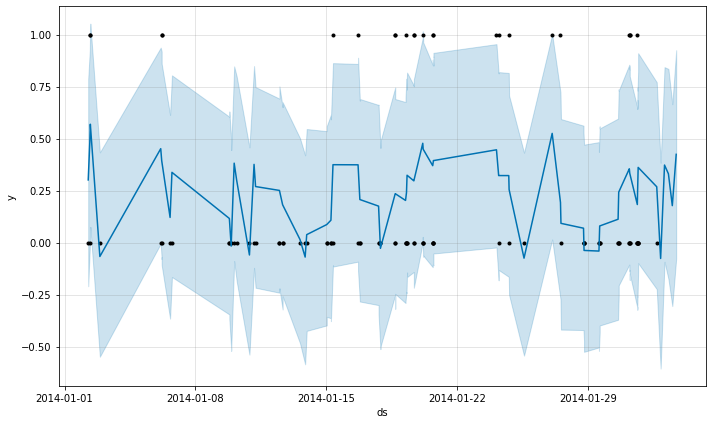

In [65]:
fig1 = m.plot(forecast)

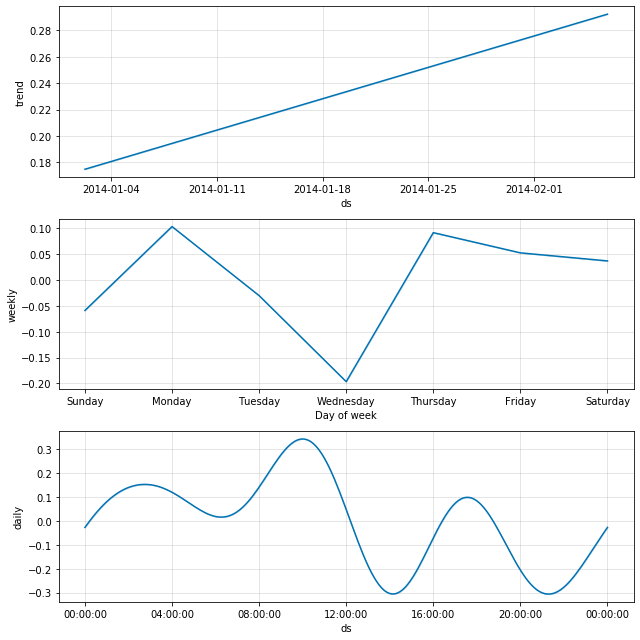

In [39]:
fig2 = m.plot_components(forecast)